##README
###Mini Project 1 Group_17</br>
- Ningchen Ma 260784056</br>
- Liang Zhao 260781081</br>
- Haowei Qiu 260762269  

There are three tasks in this Jupyter notebook corresponding to task1, task2 and task3 in the assignment.

**Note:** task1, the merged dataset file is named "merged.csv"

In [ ]:
#all library used is defined here
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt 
from ipywidgets import interactive
import seaborn as sb
import csv
from numpy import genfromtxt
import pandas as pd
from sklearn import neighbors, tree
from datetime import datetime, date, time, timedelta
plt.style.use('seaborn')

##Task 1

###Load the dataset from csv files and cleanup the data
filtered data will be stored in new csv files: </br>
* filtered_dataset1.csv
* filtered_dataset2.csv</br>

We cleaned the data in dataset1 by using threshold = 0.05 * #rows</br>
We used date from 2020-3-16 to 2020-09-21</br>


In [ ]:
#load dataset1 and dataset2 into arrays
with open('2020_US_weekly_symptoms_dataset.csv', newline='') as csvfile:
  dataset1 = pd.read_csv(csvfile)
  #print(dataset1.)
  # filter out features and data
  filtered_data1 = dataset1.dropna(axis='columns', how='all')
  row_count = sum(1 for row in filtered_data1) + 1
  filtered_data1 = filtered_data1.dropna(thresh=(row_count*0.05))
  # extract date from 2020-3-16 to 2020-09-21
  filtered_data1 = filtered_data1[(filtered_data1['date'] >= '2020-03-16') & (filtered_data1['date'] <= '2020-09-21')]
  # export filtered csv file
  filtered_data1.fillna(0, inplace=True)
  filtered_data1 = filtered_data1.reset_index()
  filtered_data1 = filtered_data1.drop('index', 1)
  filtered_data1.to_csv('filtered_dataset1.csv')

  # region codes used to filter dataset2
  dataset1_regions = list(set(filtered_data1['open_covid_region_code']))
  
with open('aggregated_cc_by.csv', newline='') as csvfile:
  # we only keep four useful features
  filtered_data2 = pd.read_csv(csvfile, usecols=['open_covid_region_code', 'region_name', 'date','hospitalized_new'])
  # only keep regions appeared in dataset1
  filtered_data2 = filtered_data2.loc[filtered_data2['open_covid_region_code'].isin(dataset1_regions)]
  # extract date from 2020-3-16 to 2020-09-21 in daily bases
  filtered_data2 = filtered_data2[(filtered_data2['date'] >= '2020-03-16') & (filtered_data2['date'] <= '2020-09-21')]
  # export filtered csv file
  filtered_data2.fillna(0, inplace=True)
  filtered_data2 = filtered_data2.reset_index()
  filtered_data2 = filtered_data2.drop('index', 1)
  filtered_data2.to_csv('filtered_dataset2.csv')

### Merge dataset2 to dataset1 in weekly basis

In [ ]:
# region codes in dataset1 and dataset2
dataset2_regions = list(set(filtered_data2['open_covid_region_code']))
dataset1_regions = list(set(filtered_data1['open_covid_region_code']))
data2_tmp = filtered_data2 

# only keep regions in dataset2 if it also exists in dataset1
data2_tmp = data2_tmp.loc[data2_tmp['open_covid_region_code'].isin(dataset1_regions)]

# convert dataset2 from daily to weekly and store data into array 'tmp_weekly'
data2_tmp['date'] = pd.to_datetime(data2_tmp['date'])
data2_tmp = data2_tmp.set_index('date')
tmp_weekly = []
for r in dataset2_regions:
  data_per_region = data2_tmp.loc[data2_tmp['open_covid_region_code'] == r]
  data_per_region = data_per_region.resample('W-Mon', label='left', closed='left').sum()
  # becuase resample will delete non-integer columns, we need to append region codes again
  tmp_weekly.append(r)
  tmp_weekly.append(data_per_region)

# merge tmp_weekly to dataset1
tmp_hospitalization = pd.DataFrame()
merged = pd.DataFrame()
data1_tmp = pd.DataFrame()
for i in range(len(tmp_weekly)):
  if (i % 2) == 0:
    data1_tmp = filtered_data1.loc[filtered_data1['open_covid_region_code'] == tmp_weekly[i]]
    tmp_hospitalization = data1_tmp
    tmp_hospitalization['hospitalized_new'] = np.array(tmp_weekly[i+1])
    merged = pd.concat([merged, tmp_hospitalization], axis=0).reset_index(drop=True)

merged = merged.reset_index()
merged = merged.drop('index', 1)
merged.to_csv('merged.csv')
print("Merged file successfully created")
print()
print()

Merged file successfully created




/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
df = pd.read_csv("merged.csv")

In [ ]:
with open('./merged.csv', newline='') as csvfile:
  merged = list(csv.reader(csvfile))

### Normalize the merged dataset

In [ ]:
def record_location(dataset,table_region_index):
  output = []
  start_index = 0
  end_index = 0
  output.append(start_index)
  region_name = dataset[0][table_region_index]
  for i in range(len(dataset)):
    if (dataset[i][table_region_index] == region_name):
      end_index = end_index + 1
    else:
      output.append(end_index)
      start_index = end_index + 1
      output.append(start_index)
      end_index = start_index
      region_name = dataset[i][table_region_index]
  output.append(len(dataset)-1)
  return output

In [ ]:
list_record_init = record_location(merged,4)
regional_list = []
national_list = []
temp = []
for i in range(1,17):
  index_a = list_record_init[2*i] - 1
  index_b = list_record_init[2*i+1]
  for j in range(index_a,index_b):
    for k in range(7,len(merged[0])-1):
      temp.append(merged[j][k])
    regional_list.append(temp)
    temp = []
  national_list.append(regional_list)
  regional_list = []


In [ ]:
micro_temp = []
micro_medians = []
macro_medians = []
for i in range(16):
  temp_regional = national_list[i]
  for j in range(len(temp_regional[0])):
    for k in range(len(temp_regional)):
      if float(temp_regional[k][j]) != 0:
        micro_temp.append(temp_regional[k][j])
    if len(micro_temp) != 0:
      micro_temp = np.asarray(micro_temp)
      micro_temp = micro_temp.astype(np.float)
      micro_median = np.median(micro_temp)
      micro_medians.append(micro_median)
      # print("===============")
      # print(j)
      # print(micro_medians)
      # print("===============")
      micro_temp = []
    else:
      micro_temp = []
      continue
  if len(micro_medians) != 0:
    micro_medians = np.asarray(micro_medians)
    micro_medians = micro_medians.astype(np.float)
    macro_median = np.median(micro_medians)
    macro_medians.append(macro_median)
    # print("************************")
    # print(i)
    # print(macro_medians)
    # print("************************")
    micro_medians = []
  else:
    macro_medians.append(0)
    micro_medians = []
print(macro_medians)

[8.19, 23.215, 4.24, 3.42, 15.649999999999999, 8.692499999999999, 9.705, 15.405000000000001, 14.66, 12.445, 19.4125, 18.515, 11.375, 37.225, 10.157499999999999, 11.27]


In [ ]:
print(merged[1][7])
for i in range(1,17):
  index_a = list_record_init[2*i] - 1
  index_b = list_record_init[2*i+1]
  for j in range(index_a,index_b):
    for k in range(7,len(merged[0])-1):
      merged[j][k] = float(merged[j][k]) / macro_medians[i-1]
print(merged[1][7])

8.08
0.9865689865689866


In [ ]:
#for i in range(len(merged[1])):
#  print(merged[99][i])

#Task 2

## 2.1: Visualizing Evolution

Here I choosed 3 most popular symptoms to do the analysis.

- **What do I mean by "popular"?** \\
  Here, I choose those with the least number of non-zero entries. That is, symptoms with the most frequent record are considered to be "popular".

I decided to use line graphs to represent the evolution of symptoms across regions over the time. Because line graph is quite informative when dealing with tracking changes over short or long periods of time. 

Line graphs are useful in that they show data variables and trends very clearly and can help to make predictions about the results of data not yet recorded. 

In [ ]:
df = pd.read_csv("merged.csv")
frequency = np.array(df.astype(bool).sum(axis=0))

#The frequency for non-zeros entries in each column
frequency = (((frequency/4.48))[7:])#The frequency for non-zeros entries in each column

sorted_ind = np.argsort(frequency)

#We will only do 3 most popular symptoms for the sake of analysis
import_sym = sorted_ind[[-1,-2,-3]]
import_sym  = import_sym + 7

cols = np.array(df.columns)

syms_data = df.iloc[:,import_sym]
syms_name = cols[import_sym]
syms_name = np.array(syms_name)

#Each row is a data point with 3 features (3 most popular symptoms)
data_set = np.array(syms_data)# 448 * 3
data_set = np.array(np.split(data_set, 16)) # 16 * 28 * 3

date = df.iloc[0:28,6]
date = np.array(date)#Stores the array of dates from 2020-3-16 to 2020-9-21


df = pd.read_csv("merged.csv")
new_df = df.loc[ (df['date'] == '2020-03-16')]

#Get region codes array
region_codes = np.array(new_df.iloc[:,1])

colors = np.array(['orange','lime','b','g','r','c','m','y','k','w','pink','lightpink','cyan','teal','yellowgreen','skyblue'])


### Ploting for Symptom1

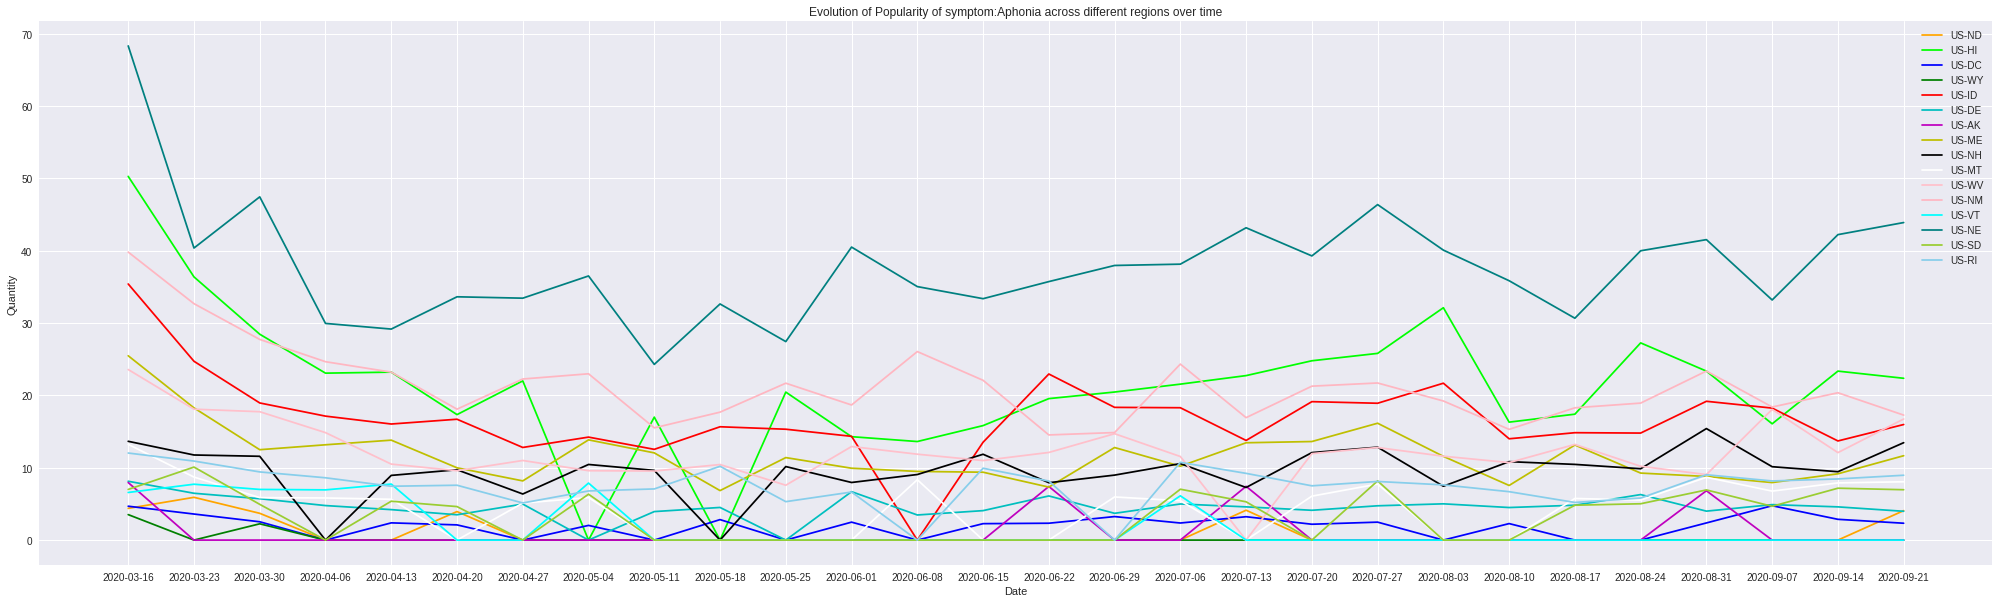

In [ ]:
plt.figure(figsize=(35,10))
x = date
y = data_set[1,:,1]

for i in range(16):
    fig = plt.plot(x, data_set[i,:,0],c=colors[i], label = region_codes[i])
    
plt.title(f'Evolution of Popularity of {syms_name[0]} across different regions over time')
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.show()


### Ploting for Symptom2

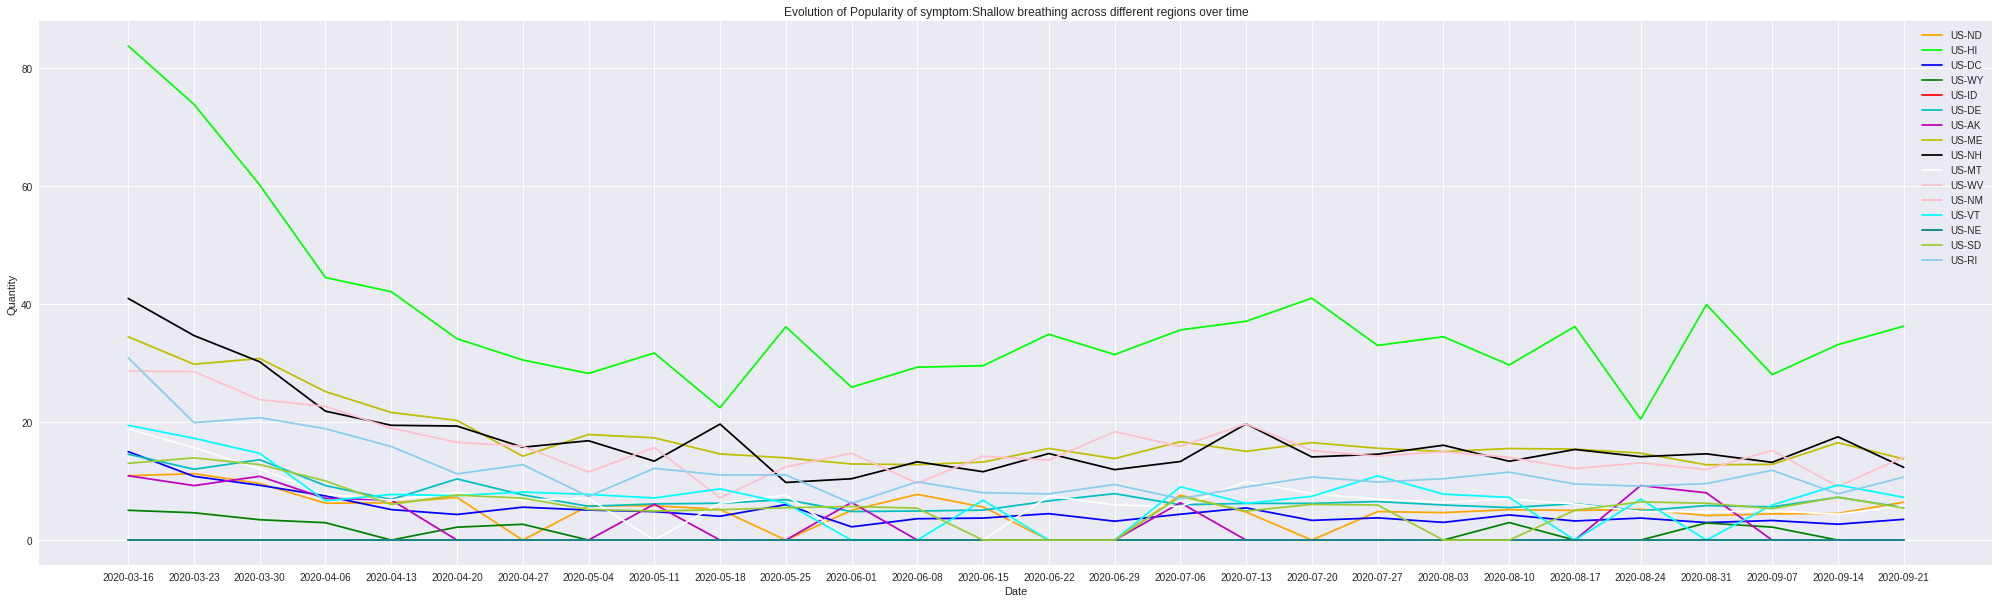

In [ ]:
plt.figure(figsize=(35,10))
x = date
for i in range(16):
    fig = plt.plot(x, data_set[i,:,1],c=colors[i], label = region_codes[i])
    
plt.title(f'Evolution of Popularity of {syms_name[1]} across different regions over time')
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.show()

### Ploting for Symptom3

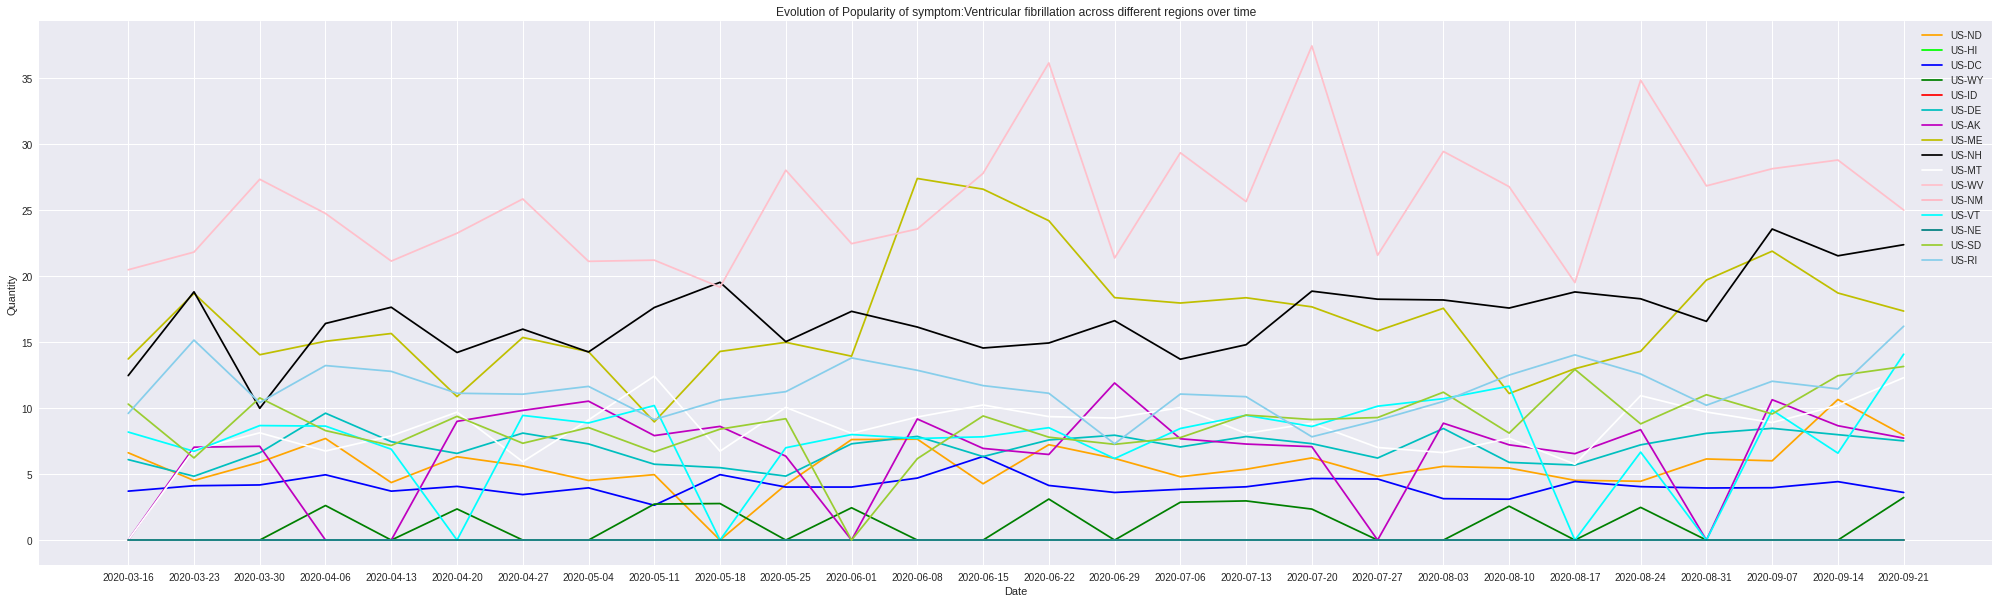

In [ ]:
plt.figure(figsize=(35,10))
x = date
for i in range(16):
    fig = plt.plot(x, data_set[i,:,2],c=colors[i], label = region_codes[i])
    
plt.title(f'Evolution of Popularity of {syms_name[2]} across different regions over time')
plt.xlabel("Date")
plt.ylabel("Quantity")
plt.legend()
plt.show()

###Normolized data

In [ ]:
#Normailize region data 
def normalize(df):
  new_df = df.iloc[:,7:]
  num_col = np.array(df.columns)
  #print(num_col.shape)

  medians = np.array(df.median(axis = 0))
  #print(means.shape)

  for i in range(medians.shape[0]-1):
    if (medians[i+1] != 0):
      df[num_col[i+7]] = df[num_col[i+7]]/medians[i+1]
  return df

###Export normalized csv files for each region

In [ ]:
def export_regions():

    df = pd.read_csv("merged.csv")
    new_df = df.loc[ (df['date'] == '2020-03-16')]
    #Get region codes array
    region_codes = np.array(new_df.iloc[:,1])

    #Export csv file for each region
    for index in range(region_codes.shape[0]):

        #Current region data 
        temp = df.loc[((df['open_covid_region_code'] == region_codes[index]))]
        #temp = normalize(temp)
        temp.to_csv(f'region{index}.csv',index = 0)
        
export_regions()

### Delet files

In [ ]:
#Delete files...
import os
for i in range(16):
  os.remove(f'region{i}.csv') 


## 2.2: PCA

### For the Raw Dataset

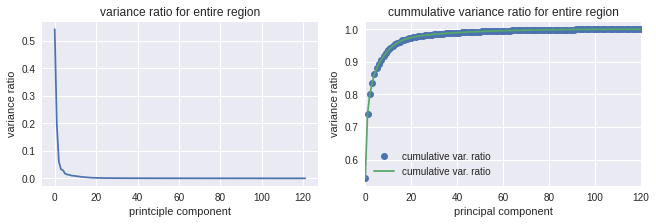

In [ ]:
new_df = pd.read_csv("merged.csv")
new_df = new_df.iloc[:,7:]
#print(new_df.mean(axis = 0))
new_df = new_df - new_df.mean(axis = 0)#Normalize the data set, make the mean for each feature eqauls to 0
    
    
x = np.array(new_df)#x[i] is the ith "data point"
# c: the covariance matrix (normalized)
c = x.T @ x / (x.shape[0])
lam, q = np.linalg.eigh(c) # lam(bda) is vector of eigenvalues in ascending order, columns of q are eigenvectors

lam_sum = np.sum(lam)
    
r = lam/lam_sum;
r = np.flip(r)# r: var ratio
    
############################ Ploting of variance ratio ########################################    
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(9,3))
        
plt.plot(np.cumsum(r), "o", label="cumulative var. ratio")

axes[0].plot(r, label="var. for each PC")
axes[0].set_xlabel('printciple component')
axes[0].set_ylabel( 'variance ratio')
axes[0].set_title('variance ratio for entire region')
axes[1].plot(np.cumsum(r), label="cumulative var. ratio")
axes[1].set_title('cummulative variance ratio for entire region')
variances = np.var(x @ q.T, 0)

plt.xlabel("principal component")
plt.xlim([0,120])
plt.ylabel("variance ratio")

plt.legend()
plt.show()

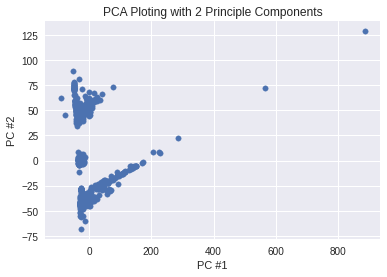

Text(0.5, 0.92, 'PCA Ploting with 3 Principle Components')

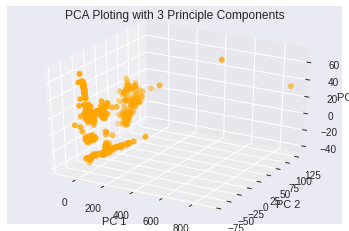

In [ ]:
new_df = pd.read_csv("merged.csv")
new_df = new_df.iloc[:,7:]
#print(new_df.mean(axis = 0))
new_df = new_df - new_df.mean(axis = 0)#Normalize the data set, make the mean for each feature eqauls to 0
       
x = np.array(new_df)#x[i] is the ith "data point"

from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(x)
x_reduced = pca.transform(x)
x0 = x_reduced[:,0]
x1 = x_reduced[:,1]
x2 = x_reduced[:,2]

plt.scatter(x_reduced[:,0], x_reduced[:,1],s = 30)
plt.xlabel("PC #1")
plt.ylabel("PC #2")
plt.title("PCA Ploting with 2 Principle Components")
plt.show()


# # Plot predictions
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(x0,x1,x2,marker='o',s=30,c='orange')

ax.set_xlabel("PC 1")
ax.set_ylabel("PC 2")
ax.set_zlabel("PC 3")
ax.set_title("PCA Ploting with 3 Principle Components")

## 2.3: K-Means Cluster

In [ ]:
class KMeans:
    
    def __init__(self, k=5, max_iters=100, verbose=True):
        self.k = k
        self.max_iters = max_iters
        self.verbose = verbose
    
    def fit(self, x):
        
        #n: number of instances
        #d: number of features
        n,d = x.shape
        #Randomly assigne k points as centroids
        init_centers = np.random.choice(n, self.k, replace=False)
        
        #mu: array of centroids
        mu = x[init_centers]
        
        #Run at most 100 times
        for t in range(self.max_iters):
            
            distances = np.sum((mu[None,:,:] - x[:,None,:])**2, -1) # n x k
            
            #Strores clusters with min distance as points' membership
            #Reassign membership
            membership = np.argmin(distances, 1)# membership[i] ==> the membership for the ith elemenet in x
            
            mu_new = mu.copy()
            
            #Re-calculate centroids for each cluster
            for i in range(self.k):
                
                mu_new[i,:] = np.mean( x [ membership == i ] , 0)
                
            #If cluster centroids converge, then stop the iteration
            if np.allclose(mu_new, mu):
                if self.verbose:
                    print(f'converged after {t} iterations, cost {np.sum(np.min(distances,1))}')
                break
            mu = mu_new
            
        return mu, membership

We will project both classified clusters in 2d principle components.

### K-Means on PCA (lower dimension)

In [ ]:
new_df = pd.read_csv("merged.csv")
new_df = new_df.iloc[:,8:]
#print(new_df.mean(axis = 0))
new_df = new_df - new_df.mean(axis = 0)#Normalize the data set, make the mean for each feature eqauls to 0
       
x = np.array(new_df)#x[i] is the ith "data point"

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
pca.fit(x)
x_reduced = pca.transform(x)
x0 = x_reduced[:,0]
x1 = x_reduced[:,1]

converged after 7 iterations, cost 1203872.835212027


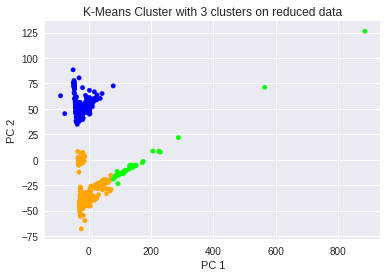

In [ ]:
k = 3

kmeans = KMeans(k)
#mu: array of centroids, mu[i] ==> the centroid of ith cluster
#cl: membership of data points
x = np.column_stack((x0,x1))
mu, cl = kmeans.fit(x)


#print()
#print(cl.shape)
#print(x.shape)

plt.scatter(x0,x1,marker='o',s=20, c = colors[cl])
plt.title(f'K-Means Cluster with {k} clusters on reduced data')
plt.xlabel("PC 1")
plt.ylabel("PC 2")

#formatter = plt.FuncFormatter(lambda i)
#plt.colorbar(ticks=4)
plt.show()
#plt.legend()

**The cluster classifications we got from reduced data set (with only 2 PC dimensions) are most of time the same, except for some swapings, which does not harm our analytical result.** This is just the K-means on a 2d basis.


###K-Means for Raw Data (higher dimension)

converged after 8 iterations, cost 2249589.6657793834


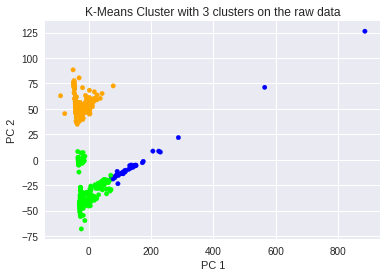

In [ ]:
new_df = pd.read_csv("merged.csv")
new_df = new_df.iloc[:,7:]
x = np.array(new_df)
#print(x.shape)

k = 3
kmeans = KMeans(k)
#mu: array of centroids, mu[i] ==> the centroid of ith cluster
#cl: membership of data points

mu, cl = kmeans.fit(x)

#print(cl.shape)
#print(x.shape)

plt.scatter(x0,x1,marker='o',s=20, c = colors[cl])
plt.title(f'K-Means Cluster with {k} clusters on the raw data')
plt.xlabel("PC 1")
plt.ylabel("PC 2")

#plt.colorbar(ticks=np.arange(k))

plt.show()

**However, the performance of K-Means varies a lot on higher-d data set (our 488-D raw data).**

#Task 3

### 3.1 Split data

In [ ]:
def count_regions(dataset,table_region_index):
  num_regions = 1
  region_name = dataset[1][table_region_index]
  for i in range(1,len(dataset)):
    if region_name == dataset[i][table_region_index]:
      continue
    else:
      num_regions += 1
      region_name = dataset[i][table_region_index]
  return num_regions

In [ ]:
def sort_by_time(dataset,table_time_index):
  dataset = dataset[1:]
  dataset = sorted(dataset,key=lambda x: x[table_time_index])
  return dataset

In [ ]:
table_region_index = 4
tv_dataset = merged
num_regions = count_regions(tv_dataset,table_region_index)

list_record = record_location(tv_dataset,4)
print(int(num_regions*0.8))
new_list = [1, 85, 85, 169, 169, 253, 253, 337, 337, 448]

12


#### Based on Regions

In [ ]:
x_rest = []
y_rest = []
temp = []
for i in range(1,len(tv_dataset)):
  y_rest.append(tv_dataset[i][len(tv_dataset[1])-1])
y_rest = np.asarray(y_rest)

for i in range(1,len(tv_dataset)):
  for j in range(7,len(tv_dataset[0])-1):
    temp.append(tv_dataset[i][j])
  x_rest.append(temp)
  temp = []
x_rest = np.asarray(x_rest)

n_rest = len(x_rest)
x_rest=x_rest.astype(np.float)
y_rest=y_rest.astype(np.float)

In [ ]:
training_set = []
validation_set = []
temp = []

for i in range(new_list[0],new_list[7]):
  for j in range(7,len(tv_dataset[0])):
    temp.append(tv_dataset[i][j])
  training_set.append(temp)
  temp = []
training_set = np.asarray(training_set)

for i in range(new_list[8],new_list[9]):
  for j in range(7,len(tv_dataset[0])):
    temp.append(tv_dataset[i][j])
  validation_set.append(temp)
  temp = []
validation_set = np.asarray(validation_set)

training_set = training_set.astype(np.float)
validation_set = validation_set.astype(np.float)

#### Based on Time

In [ ]:
tv_dataset_time = sort_by_time(merged,6)

x_rest_time = []
y_rest_time = []
temp = []
for i in range(1,len(tv_dataset_time)):
  y_rest_time.append(tv_dataset[i][len(tv_dataset_time[1])-1])
y_rest_time = np.asarray(y_rest_time)

for i in range(1,len(tv_dataset_time)):
  for j in range(7,len(tv_dataset_time[0])-1):
    temp.append(tv_dataset_time[i][j])
  x_rest_time.append(temp)
  temp = []
x_rest_time = np.asarray(x_rest_time)

n_rest_time = len(x_rest_time)
x_rest_time=x_rest_time.astype(np.float)
y_rest_time=y_rest_time.astype(np.float)

In [ ]:
training_set_time = []
validation_set_time = []
temp = []

for i in range(1,int(len(tv_dataset_time)*0.8)):
  for j in range(7,len(tv_dataset_time[0])):
    temp.append(tv_dataset_time[i][j])
  training_set_time.append(temp)
  temp = []

for i in range(int(len(tv_dataset_time)*0.8),len(tv_dataset_time)):
  for j in range(7,len(tv_dataset_time[0])):
    temp.append(tv_dataset_time[i][j])
  validation_set_time.append(temp)
  temp = []

training_set_time = np.asarray(training_set_time)
validation_set_time = np.asarray(validation_set_time)

### 3.2 KNN and Decision Tree with Cross-Validation

In [ ]:
def cross_validate(n, n_folds=5):
    for f in range(n_folds):
        tr_inds = []
        val_inds = [*range(int(new_list[2*f]) , int(new_list[2*f+1]))]
        if f > 0:
            tr_inds = [*range(int(new_list[2*f]))]
        if f < n_folds - 1:
            tr_inds = tr_inds + [*range(int(new_list[2*f+1]), n)]
        yield tr_inds, val_inds

In [ ]:
def cross_validate_by_time(n, n_folds=5):
    n_val = n // n_folds
    for f in range(n_folds):
        tr_inds = []
        val_inds = [*range(f * n_val, (f+1)*n_val)]
        if f > 0:
            tr_inds = [*range(f*n_val)]
        if f < n_folds - 1:
            tr_inds = tr_inds + [*range((f+1)*n_val, n)]
        yield tr_inds, val_inds

#### By region

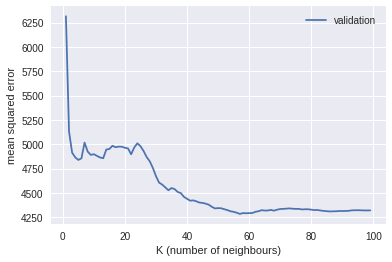

In [ ]:
num_folds = 5
K_list = range(1,100)
loss = lambda y, yh: np.mean((y-yh)**2)
err_valid = np.zeros((len(K_list), num_folds))
for i, K in enumerate(K_list):
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        model = neighbors.KNeighborsRegressor(n_neighbors=K)
        model = model.fit(x_rest[tr], y_rest[tr])
        err_valid[i, f] = loss(y_rest[val], model.predict(x_rest[val]))
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_rest, y_rest)

plt.plot(K_list, np.mean(err_valid, axis=1),  label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

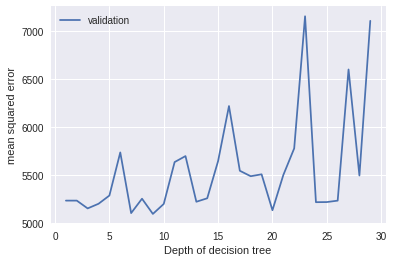

In [ ]:
num_folds = 5
D_list = range(1,30)
loss = lambda y, yh: np.mean((y-yh)**2)
err_valid = np.zeros((len(D_list), num_folds))
for i, D in enumerate(D_list):
    for f, (tr, val) in enumerate(cross_validate(n_rest, num_folds)):
        model = tree.DecisionTreeClassifier(max_depth=D)
        model = model.fit(x_rest[tr], y_rest[tr])
        err_valid[i, f] = loss(y_rest[val], model.predict(x_rest[val])) 
    model = tree.DecisionTreeClassifier(max_depth=D)
    model = model.fit(x_rest, y_rest)

plt.plot(D_list, np.mean(err_valid, axis=1),  label='validation')
plt.legend()
plt.xlabel('Depth of decision tree')
plt.ylabel('mean squared error')
plt.show()

#### By time

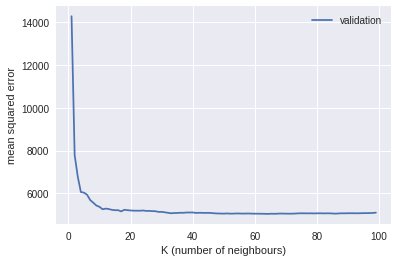

In [ ]:
num_folds = 5
K_list = range(1,100)
err_valid = np.zeros((len(K_list), num_folds))
for i, K in enumerate(K_list):
    for f, (tr, val) in enumerate(cross_validate_by_time(n_rest_time, num_folds)):
        model = neighbors.KNeighborsRegressor(n_neighbors=K)
        model = model.fit(x_rest_time[tr], y_rest_time[tr])
        err_valid[i, f] = loss(y_rest_time[val], model.predict(x_rest_time[val]))
    model = neighbors.KNeighborsRegressor(n_neighbors=K)
    model = model.fit(x_rest_time, y_rest_time)

plt.plot(K_list, np.mean(err_valid, axis=1),  label='validation')
plt.legend()
plt.xlabel('K (number of neighbours)')
plt.ylabel('mean squared error')
plt.show()

In [ ]:
num_folds = 5
D_list = range(1,30)
err_valid = np.zeros((len(D_list), num_folds))
for i, D in enumerate(K_list):
    for f, (tr, val) in enumerate(cross_validate_by_time(n_rest_time, num_folds)):
        model = tree.DecisionTreeClassifier(max_depth=D)
        model = model.fit(x_rest_time[tr], y_rest_time[tr])
        err_valid[i, f] = loss(y_rest_time[val], model.predict(x_rest_time[val]))
    model = tree.DecisionTreeClassifier(max_depth=D)
    model = model.fit(x_rest_time, y_rest_time)

plt.plot(D_list, np.mean(err_valid, axis=1),  label='validation')
plt.legend()
plt.xlabel('Depth of Decision Tree')
plt.ylabel('mean squared error')
plt.show()